/var/folders/t8/kft3r9x14dv07wt1prr3tmc00000gn/T/ipykernel_26286/3817124481.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  oilData['dcoilwtico'].fillna(method='bfill', inplace=True)
/var/folders/t8/kft3r9x14dv07wt1prr3tmc00000gn/T/ipykernel_26286/3817124481.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  oilData['dcoilwtico'].fillna(method='bfill', inplace=True)


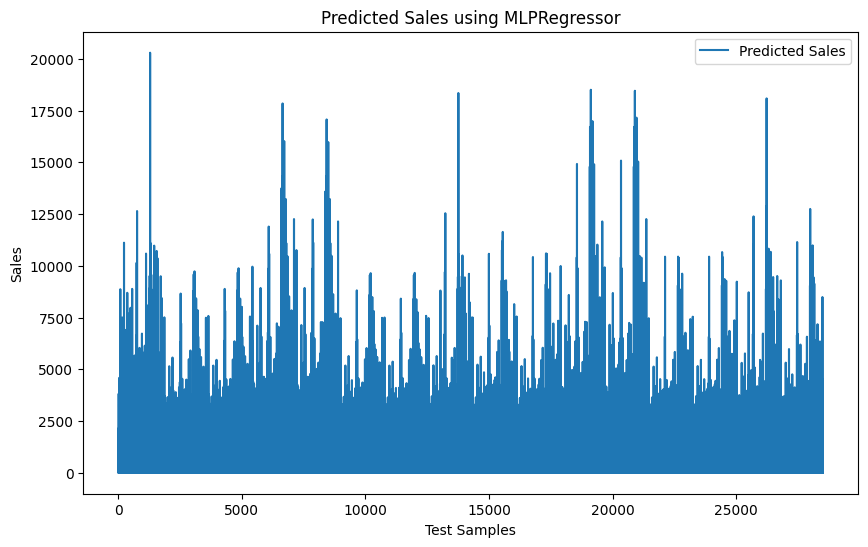

In [10]:
# submission best = 0.66668
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neural_network import MLPClassifier, MLPRegressor

# load each dataset
holidayEventsData = pd.read_csv('store-sales-time-series-forecasting/holidays_events.csv')
oilData = pd.read_csv('store-sales-time-series-forecasting/oil.csv')
storesData = pd.read_csv('store-sales-time-series-forecasting/stores.csv')
transactionsData = pd.read_csv('store-sales-time-series-forecasting/transactions.csv')
testData = pd.read_csv('store-sales-time-series-forecasting/test.csv', parse_dates=['date'])
trainData = pd.read_csv('store-sales-time-series-forecasting/train.csv', parse_dates=['date'])

# change to datetime
trainData['date'] = pd.to_datetime(trainData['date'])
testData['date'] = pd.to_datetime(testData['date'])
oilData['date'] = pd.to_datetime(oilData['date'])
holidayEventsData['date'] = pd.to_datetime(holidayEventsData['date'])
transactionsData['date'] = pd.to_datetime(transactionsData['date'])

# fix similar column names
storesData.rename(columns={'type': 'store_type'}, inplace=True)
holidayEventsData.rename(columns={'type': 'holiday_type'}, inplace=True)

# fill missing
oilData['dcoilwtico'].fillna(method='bfill', inplace=True)

#remove 0 sales
trainData = trainData[trainData['sales'] > 0]

# normalize sales
trainData['sales'] = np.log1p(trainData['sales'])

# merging data
train = trainData.merge(storesData, on='store_nbr', how='left')
train = train.merge(oilData, on='date', how='left')
train = train.merge(holidayEventsData, on='date', how='left')
train.fillna(0, inplace=True)
testData = testData.merge(storesData, on='store_nbr', how='left')
testData = testData.merge(oilData, on='date', how='left')
testData = testData.merge(holidayEventsData, on='date', how='left')
testData.fillna(0, inplace=True)

# convert all categorical to numerical
for col in ['family', 'city', 'state', 'store_type', 'holiday_type', 'locale', 'description', 'locale_name', 'transferred']:
    if col in train.columns:
        train[col] = train[col].astype('category').cat.codes
        testData[col] = testData[col].astype('category').cat.codes

clf = MLPRegressor(solver='adam', alpha=1e-5, hidden_layer_sizes=(100, ), max_iter=500, learning_rate = 'adaptive',random_state=1)

# feature selection
xTrain = train.drop(['date', 'id', 'sales'], axis=1)
yTrain = train['sales']
xTest = testData.drop(['date', 'id'], axis=1)
selector = SelectKBest(f_regression, k=10)
xTrain = selector.fit_transform(xTrain, yTrain)
xTest = selector.transform(xTest)

# scale data
scaler = StandardScaler()
xTrain = scaler.fit_transform(xTrain)
xTest = scaler.transform(xTest)

# fit model
clf.fit(xTrain, yTrain)
yPred = np.expm1(clf.predict(xTest))

# export to csv in format (id, sales)
testData['sales'] = yPred
testData[['id', 'sales']].to_csv('submission.csv', index=False)